# Prediction of the rent prices 
After the cleaning and data processing part now let's jump to the main objective of this project the rent prediction part. For that we will use many regression based model as we will present further after. 


## 1.   Feature engineering 

1.   Changing catergorical data to ordinal data
2.   Standardization of the data


## 2.   Applying regression predictive model

### Models to be used for the prediction
> * Lasso Regression
> * Ridge Regression
> * Kfold Regularization

* First let's take a look on our cleaned dataset, in order to do it let's import our previous results

In [ ]:
# Access files from Google Drive
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plb 
%matplotlib inline

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing the data and data processing

In [ ]:
sf = pd.read_csv("./gdrive/My Drive/Projecto_BD/sf_clean.csv")

In [ ]:
#Re-adapting hood_district names
sf['hood_district'] = sf['hood_district'].astype(int)
sf['hood_district'] = sf['hood_district'].astype(str)

In [ ]:
sf.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,3920,805.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,6
1,3870,805.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,6
2,5105,1388.0,2.0,2.5,(a) in-unit,(a) both,(c) multi,(b) protected,6
3,4850,1388.0,2.0,2.5,(a) in-unit,(a) both,(c) multi,(b) protected,6
4,4750,1388.0,2.0,2.5,(a) in-unit,(a) both,(c) multi,(b) protected,6


* Limiting the scope of our data by limiting the outliers we're gonna pick to rental offers under **6000$**

In [ ]:
sf = sf[sf['price'] < 6000]

* Converting nominal to ordinal variables 

In [ ]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 1087
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          987 non-null    int64  
 1   sqft           987 non-null    float64
 2   beds           987 non-null    float64
 3   bath           987 non-null    float64
 4   laundry        987 non-null    object 
 5   pets           987 non-null    object 
 6   housing_type   987 non-null    object 
 7   parking        987 non-null    object 
 8   hood_district  987 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 77.1+ KB


* As we can see our data have for categorical values :

1.   Laundry
2.   Pets
3.   Housing type
4.   Parking
5.   Hood District




Let's begin first with Laundry for that we will create a dictionnary where each **nominal** value will have its **ordinal** equivalent 

In [ ]:
laundry_dict = {'(a) in-unit': 2, 
               '(b) on-site': 1,
               '(c) no laundry': 0}
sf = sf.replace({'laundry': laundry_dict})

In [ ]:
sf.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,3920,805.0,1.0,1.0,2,(a) both,(c) multi,(b) protected,6
1,3870,805.0,1.0,1.0,2,(a) both,(c) multi,(b) protected,6
2,5105,1388.0,2.0,2.5,2,(a) both,(c) multi,(b) protected,6
3,4850,1388.0,2.0,2.5,2,(a) both,(c) multi,(b) protected,6
4,4750,1388.0,2.0,2.5,2,(a) both,(c) multi,(b) protected,6


Let's do the same for the other categorical values

In [ ]:
sf.parking.unique()

array(['(b) protected', '(d) no parking', '(c) off-street', '(a) valet'],
      dtype=object)

In [ ]:
parking_dict = {'(a) valet': 3, 
               '(b) protected': 2,
               '(c) off-street': 1,
               '(d) no parking': 0}

sf = sf.replace({'parking': parking_dict})

* Same goes for pets but here we're gonna simplify even more the transformation by having a binary value 

In [ ]:
sf.pets.unique()

array(['(a) both', '(d) no pets', '(c) cats', '(b) dogs'], dtype=object)

In [ ]:
pets_dict = {'(a) both': 1, '(b) dogs': 1,
            '(c) cats': 1,'(d) no pets': 0}
sf = sf.replace({'pets': pets_dict})

In [ ]:
sf.housing_type.unique()

array(['(c) multi', '(b) double', '(a) single'], dtype=object)

As we've seen in EDA phase the housing type don't give any more information about the quality and the rent price of the appartement so we're gonna drop it 

In [ ]:
sf=sf.drop(['housing_type'],axis=1)

Now let's face our last categorical value the **'neighborhood districts'**

In [ ]:
sf=pd.get_dummies(sf)

In [ ]:
sf=sf.drop(['hood_district_10'],axis=1)

In [ ]:
#Encapsulate our Data into a csv file
sf.to_csv('sf_final.csv', index=False)

In [ ]:
sf.head()

,price,sqft,beds,bath,laundry,pets,parking,hood_district_1,hood_district_2,hood_district_3,hood_district_4,hood_district_5,hood_district_6,hood_district_7,hood_district_8,hood_district_9
0,3920,805.0,1.0,1.0,2,1,2,0,0,0,0,0,1,0,0,0
1,3870,805.0,1.0,1.0,2,1,2,0,0,0,0,0,1,0,0,0
2,5105,1388.0,2.0,2.5,2,1,2,0,0,0,0,0,1,0,0,0
3,4850,1388.0,2.0,2.5,2,1,2,0,0,0,0,0,1,0,0,0
4,4750,1388.0,2.0,2.5,2,1,2,0,0,0,0,0,1,0,0,0


## Modeling

1. ***Train/Test split***

* First let's get rid of our feature columns to predict which is the price here

In [ ]:
X, y = sf.drop('price',axis=1), sf['price']

#Train&Test
# Let's choose 20% of the data for testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Training&Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=4)

In [ ]:
poly = PolynomialFeatures(degree=2, interaction_only=False)
    
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

* First in order to prepare our data to the regularization's techniques let's first apply standardization to avoid overfitting the data and lower their dispersion 

In [ ]:
# Scaling for Ridge / Lasso 
scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_val_scaled = scaler.transform(X_val_poly)
X_test_scaled = scaler.transform(X_test_poly)

## Machine learning models 


### 2. Regularization's techniques

> **2.1 Lasso** :



In [ ]:
alphavec = 10**np.linspace(-2,1,10000)

lasso_model = LassoCV(alphas=alphavec, cv=3).fit(X_train_scaled, y_train)


* Let's identify the best alpha obtained from the cross validation 

In [ ]:
lasso_alpha = lasso_model.alpha_
lasso_alpha

1.3731366893478814

Now that we have our best parameter let's apply the lasso's regressor to our training set  

In [ ]:
las=Lasso(alpha=lasso_alpha)
las.fit(X_train_scaled,y_train)
#Using R^2 to compute the accuracy of the pred
print(f'Lasso Regression train R^2: {las.score(X_train_scaled, y_train):.5f}')
print(f'Lasso Regression val R^2: {las.score(X_val_scaled, y_val):.5f}')
print("")
#Using RMSE to compute the error
print(f'Lasso Regression RMSE (train): {mean_squared_error(y_train, las.predict(X_train_scaled), squared=False):.5f}')
print(f'Lasso Regression RMSE (val): {mean_squared_error(y_val, las.predict(X_val_scaled), squared=False):.5f}')


Lasso Regression train R^2: 0.77259
Lasso Regression val R^2: 0.59567

Lasso Regression RMSE (train): 516.74670
Lasso Regression RMSE (val): 674.18450


* The score is high in training and average one in Validation for both **RMSE** and **R^2**



> **2.2 Ridge** :



In [ ]:
alphavecr=10*np.linspace(-1,1,10000)

ridge_model=RidgeCV(alphas=alphavecr,cv=3)
ridge_model.fit(X_train_scaled,y_train)

RidgeCV(alphas=array([-10.       ,  -9.9979998,  -9.9959996, ...,   9.9959996,
         9.9979998,  10.       ]),
        cv=3)

In [ ]:
ridge_alpha=ridge_model.alpha_
ridge_alpha

1.341134113411342

In [ ]:
rid=Ridge(alpha=ridge_alpha)
rid.fit(X_train_scaled,y_train)
print(f'Ridge Regression train R^2: {rid.score(X_train_scaled, y_train):.5f}')
print(f'Ridge Regression val R^2: {rid.score(X_val_scaled, y_val):.5f}')
print("")
print(f'Ridge Regression RMSE (train): {mean_squared_error(y_train, rid.predict(X_train_scaled), squared=False):.5f}')
print(f'Ridge Regression RMSE (val): {mean_squared_error(y_val, rid.predict(X_val_scaled), squared=False):.5f}')


Ridge Regression train R^2: 0.77580
Ridge Regression val R^2: 0.60265

Ridge Regression RMSE (train): 513.08999
Ridge Regression RMSE (val): 668.33680


* With Try with some other parameters for alpha to see if there's any amelioration

In [ ]:
alphavecr=10*np.linspace(-2,2,500)

ridge_model=RidgeCV(alphas=alphavecr,cv=3)
ridge_model.fit(X_train_scaled,y_train)

RidgeCV(alphas=array([-20.        , -19.91983968, -19.83967936, -19.75951904,
       -19.67935872, -19.5991984 , -19.51903808, -19.43887776,
       -19.35871743, -19.27855711, -19.19839679, -19.11823647,
       -19.03807615, -18.95791583, -18.87775551, -18.79759519,
       -18.71743487, -18.63727455, -18.55711423, -18.47695391,
       -18.39679359, -18.31663327, -18.23647295, -18.15631263,
       -18.0761523 , -17.99599198,...
        17.51503006,  17.59519038,  17.6753507 ,  17.75551102,
        17.83567134,  17.91583166,  17.99599198,  18.0761523 ,
        18.15631263,  18.23647295,  18.31663327,  18.39679359,
        18.47695391,  18.55711423,  18.63727455,  18.71743487,
        18.79759519,  18.87775551,  18.95791583,  19.03807615,
        19.11823647,  19.19839679,  19.27855711,  19.35871743,
        19.43887776,  19.51903808,  19.5991984 ,  19.67935872,
        19.75951904,  19.83967936,  19.91983968,  20.        ]),
        cv=3)

In [ ]:
ridge_alpha=ridge_model.alpha_
ridge_alpha

1.3226452905811614

In [ ]:
rid=Ridge(alpha=ridge_alpha)
rid.fit(X_train_scaled,y_train)
print(f'Ridge Regression train R^2: {rid.score(X_train_scaled, y_train):.5f}')
print(f'Ridge Regression val R^2: {rid.score(X_val_scaled, y_val):.5f}')
print("")
print(f'Ridge Regression RMSE (train): {mean_squared_error(y_train, rid.predict(X_train_scaled), squared=False):.5f}')
print(f'Ridge Regression RMSE (val): {mean_squared_error(y_val, rid.predict(X_val_scaled), squared=False):.5f}')

Ridge Regression train R^2: 0.77582
Ridge Regression val R^2: 0.60281

Ridge Regression RMSE (train): 513.06055
Ridge Regression RMSE (val): 668.20153


* Let's decide between both of the regressor the best predictor using KFold


> **2.3 Kfold for Ridge and Lasso**



In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state = 12)

cv_rid_train_r2s, cv_las_train_r2s = [], []
cv_rid_val_r2s, cv_las_val_r2s = [], []

rid_rmses_train, las_rmses_train = [], []
rid_rmses_val, las_rmses_val = [], []

X_kf, y_kf = np.array(X), np.array(y)

for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    # Poly features
    poly = PolynomialFeatures(degree=2, interaction_only=False)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Scaling for Ridge / Lasso 
    scaler = StandardScaler(with_mean=False)
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_val_scaled = scaler.transform(X_val_poly)
    
    # Lasso
    las = Lasso(alpha=lasso_alpha)
    las.fit(X_train_scaled, y_train)
    
    cv_las_train_r2s.append(las.score(X_train_scaled, y_train))
    cv_las_val_r2s.append(las.score(X_val_scaled, y_val))
    las_rmses_train.append(mean_squared_error(y_train, las.predict(X_train_scaled), squared=False))
    las_rmses_val.append(mean_squared_error(y_val, las.predict(X_val_scaled), squared=False))
    
    # Ridge
    rid = Ridge(alpha=ridge_alpha)
    rid.fit(X_train_scaled, y_train)
    
    cv_rid_train_r2s.append(rid.score(X_train_scaled, y_train))
    cv_rid_val_r2s.append(rid.score(X_val_scaled, y_val))
    rid_rmses_train.append(mean_squared_error(y_train, rid.predict(X_train_scaled), squared=False))
    rid_rmses_val.append(mean_squared_error(y_val, rid.predict(X_val_scaled), squared=False))

# Summary output

print("Ridge")
print(f'Ridge mean cv R^2 (TRAIN): {np.mean(cv_rid_train_r2s):.5f} +- {np.std(cv_rid_train_r2s):.5f}')
print(f'Ridge mean cv R^2 (VAL): {np.mean(cv_rid_val_r2s):.5f} +- {np.std(cv_rid_val_r2s):.5f}')
print(f'Ridge mean RMSE (TRAIN): {np.mean(rid_rmses_train):.5f} +- {np.std(rid_rmses_train):.3f}')
print(f'Ridge mean RMSE (VAL): {np.mean(rid_rmses_train):.5f} +- {np.std(rid_rmses_train):.3f}')
print('')
print("Lasso")
print(f'Lasso mean cv R^2 (TRAIN): {np.mean(cv_las_train_r2s):.5f} +- {np.std(cv_las_train_r2s):.5f}')
print(f'Lasso mean cv R^2 (VAL): {np.mean(cv_las_val_r2s):.5f} +- {np.std(cv_las_val_r2s):.5f}')
print(f'Lasso mean RMSE (VAL): {np.mean(las_rmses_train):.5f} +- {np.std(las_rmses_train):.5f}')
print(f'Lasso mean RMSE (VAL): {np.mean(las_rmses_val):.5f} +- {np.std(las_rmses_val):.5f}')

Ridge
Ridge mean cv R^2 (TRAIN): 0.77624 +- 0.02028
Ridge mean cv R^2 (VAL): 0.65596 +- 0.10234
Ridge mean RMSE (TRAIN): 509.42303 +- 16.055
Ridge mean RMSE (VAL): 509.42303 +- 16.055

Lasso
Lasso mean cv R^2 (TRAIN): 0.77275 +- 0.02045
Lasso mean cv R^2 (VAL): 0.65663 +- 0.11450
Lasso mean RMSE (VAL): 513.39005 +- 16.01409
Lasso mean RMSE (VAL): 620.63818 +- 79.40852


* We will keep the ridge as our by default regressor for the rest of this study



> **2.3 Coefficients**

Let's put the light on the most explanatory variables among our variables depending on Ridge or Lasso



In [ ]:
ridge_coefs=rid.coef_
lasso_coefs=las.coef_
features=sf.columns[1:]
coefficient_data={'features':poly.get_feature_names(X.columns),
                  'Ridge':ridge_coefs,
                  'Lasso':lasso_coefs}
coef_sf=pd.DataFrame(coefficient_data)
coef_sf.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(136, 3)

In [ ]:
coef_sf.head(10)

,features,Ridge,Lasso
0,1,0.000000,0.000000
1,sqft,677.617878,768.802512
2,beds,24.066698,0.000000
3,bath,107.870807,0.000000
4,laundry,145.613574,157.711786
5,pets,-53.401127,-0.000000
6,parking,23.725012,-0.000000
7,hood_district_1,-18.363734,0.000000
8,hood_district_2,-18.474859,-0.000000
9,hood_district_3,-36.690528,-4.729673


### 3. Prediction Phase using the Ridge regressor

In [ ]:
poly = PolynomialFeatures(degree=2, interaction_only=False)
    
X_train_poly = poly.fit_transform(X)
X_test_poly = poly.transform(X_test)

# Scaling for Ridge & Lasso 
scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

In [ ]:
rid = Ridge(alpha=ridge_alpha)
rid.fit(X_train_scaled, y)

Ridge(alpha=1.3226452905811614)

#### Results

In [ ]:
print('Ridge for training score :', rid.score(X_train_scaled,y))
print('Ridge for testing score:', rid.score(X_test_scaled,y_test))
print('')
print('RMSE for training :', mean_squared_error(y, rid.predict(X_train_scaled),squared=False))
print("RMSE for test: ", mean_squared_error(y_test, rid.predict(X_test_scaled), squared=False))
print("")
print('MAE for training:',np.mean(np.abs(rid.predict(X_train_scaled)-y)))
print('MAE for testing:',np.mean(np.abs(rid.predict(X_test_scaled)-y_test)))

Ridge for training score : 0.7653172379027184
Ridge for testing score: 0.706402832216303

RMSE for training : 522.7071531029383
RMSE for test:  569.4250242124803

MAE for training: 391.6989377542524
MAE for testing: 443.68022710079765


### 4. Data visualization 

#### Comparison between actual and predicted values

In [ ]:
rid_predict=rid.predict(X_test_scaled)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


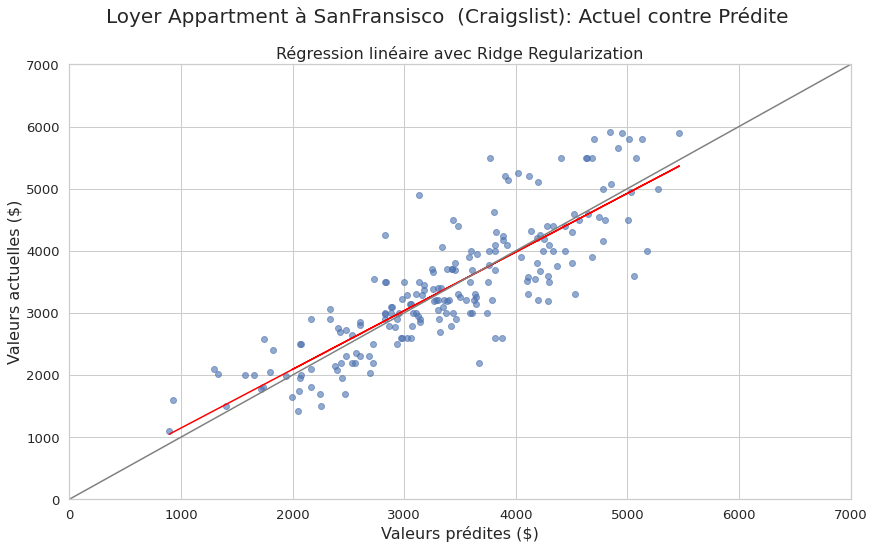

In [ ]:
plt.figure(figsize=(14, 8))
plt.scatter(rid_predict, y_test, alpha=.6) 

z = np.polyfit(rid_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(rid_predict, p(rid_predict), 'm-', color='red')
plt.plot(np.linspace(0,7000,1000), np.linspace(0,7000,1000), color='grey')

plt.xlim(0, 7000)
plt.ylim(0, 7000)

plt.suptitle('Loyer Appartment à SanFransisco  (Craigslist): Actuel contre Prédite', fontsize=20, fontname='Arial')
plt.title('Régression linéaire avec Ridge Regularization', fontsize=16, fontname='Arial')
plt.xlabel('Valeurs prédites ($)', fontsize=16, fontname='Arial')
plt.ylabel('Valeurs actuelles ($)', fontsize=16, fontname='Arial');


In [ ]:
plt.savefig('ridge_actuel_predit.png')

<Figure size 432x288 with 0 Axes>

### 5. Using Pyspark for regression

* First let's readapt the columns of our dataset by putting the feature to predict in the end

In [ ]:
col=sf.columns.tolist()
col=col[1:]+col[:-len(col)+1]
df=sf[col]
df.head()

,sqft,beds,bath,laundry,pets,parking,hood_district_1,hood_district_2,hood_district_3,hood_district_4,hood_district_5,hood_district_6,hood_district_7,hood_district_8,hood_district_9,price
0,805.0,1.0,1.0,2,1,2,0,0,0,0,0,1,0,0,0,3920
1,805.0,1.0,1.0,2,1,2,0,0,0,0,0,1,0,0,0,3870
2,1388.0,2.0,2.5,2,1,2,0,0,0,0,0,1,0,0,0,5105
3,1388.0,2.0,2.5,2,1,2,0,0,0,0,0,1,0,0,0,4850
4,1388.0,2.0,2.5,2,1,2,0,0,0,0,0,1,0,0,0,4750


In [ ]:
df.to_csv('sf_spark.csv', index=False)

* First let's import the library of pyspark

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 198 kB 79.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=476c6f56cd8b5de9f6cad7562964f1be86a1d3ad8dc581f8937e5eab63d31912
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


* Let's import our dataset using **Pyspark**

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Rent prediction in SanFransisco ") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

* Load the Dataset

In [ ]:
df = spark.read.format('com.databricks.spark.csv').\
                               options(header='true', \
                               inferschema='true').\
                               load("/content/sf_spark.csv",header=True);

df.show(5,True)
df.printSchema()

+------+----+----+-------+----+-------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+-----+
|  sqft|beds|bath|laundry|pets|parking|hood_district_1|hood_district_2|hood_district_3|hood_district_4|hood_district_5|hood_district_6|hood_district_7|hood_district_8|hood_district_9|price|
+------+----+----+-------+----+-------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+-----+
| 805.0| 1.0| 1.0|      2|   1|      2|              0|              0|              0|              0|              0|              1|              0|              0|              0| 3920|
| 805.0| 1.0| 1.0|      2|   1|      2|              0|              0|              0|              0|              0|              1|              0|              0|              0| 3870|
|1388.0| 2.0| 2.5|      2|   1|      2|           

In [ ]:
df.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+
|summary|             sqft|              beds|              bath|           laundry|              pets|           parking|    hood_district_1|    hood_district_2|     hood_district_3|     hood_district_4|    hood_district_5|    hood_district_6|    hood_district_7|    hood_district_8|    hood_district_9|             price|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+
|  count|              987| 

In [ ]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

* Convert the data to dense vector

In [ ]:
transformed= transData(df)
transformed.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[805.0,1.0,1.0,2....| 3920|
|[805.0,1.0,1.0,2....| 3870|
|[1388.0,2.0,2.5,2...| 5105|
|[1388.0,2.0,2.5,2...| 4850|
|[1388.0,2.0,2.5,2...| 4750|
+--------------------+-----+
only showing top 5 rows



* Dealing with the rest of categorical varibales 

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed)

data = featureIndexer.transform(transformed)
data.show(5,True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|[805.0,1.0,1.0,2....| 3920|[805.0,1.0,1.0,2....|
|[805.0,1.0,1.0,2....| 3870|[805.0,1.0,1.0,2....|
|[1388.0,2.0,2.5,2...| 5105|[1388.0,2.0,2.5,2...|
|[1388.0,2.0,2.5,2...| 4850|[1388.0,2.0,2.5,2...|
|[1388.0,2.0,2.5,2...| 4750|[1388.0,2.0,2.5,2...|
+--------------------+-----+--------------------+
only showing top 5 rows



* Split the data to train and test

In [ ]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(5)
testData.show(5)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|[1.0,2.0,1.0,1.0,...| 3500|[1.0,2.0,1.0,1.0,...|
|[100.0,0.0,1.0,1....| 1500|[100.0,0.0,1.0,1....|
|[140.0,0.0,1.0,0....| 1100|[140.0,0.0,1.0,0....|
|[225.0,0.0,1.0,1....| 1695|[225.0,0.0,1.0,1....|
|[230.0,1.0,1.0,1....| 1100|[230.0,1.0,1.0,1....|
+--------------------+-----+--------------------+
only showing top 5 rows

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|[200.0,0.0,1.0,1....| 1600|[200.0,0.0,1.0,1....|
|[277.0,0.0,1.0,1....| 1800|[277.0,0.0,1.0,1....|
|[279.0,1.0,1.0,1....| 1795|[279.0,1.0,1.0,1....|
|[300.0,0.0,1.0,0....| 1650|[300.0,0.0,1.0,0....|
|[300.0,0.0,1.0,0....|  225|[300.0,0.0,1.0,0....|
+--------------------+-----+--------------------+
only showing top 5 rows



In [ ]:
# Import RandomForest class
from pyspark.ml.regression import RandomForestRegressor

# Calling RandomForest algorithm
rf = RandomForestRegressor() # featuresCol="indexedFeatures",numTrees=2, maxDepth=2, seed=42

* Using a pipeline 

In [ ]:
# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])
model = pipeline.fit(trainingData)

* Prediction using the randomforest regressor

In [ ]:
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("features","label", "prediction").show(5)

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[200.0,0.0,1.0,1....| 1600|1783.3955575999832|
|[277.0,0.0,1.0,1....| 1800|1995.5670682377088|
|[279.0,1.0,1.0,1....| 1795|2252.6936234598675|
|[300.0,0.0,1.0,0....| 1650|1838.2007492872835|
|[300.0,0.0,1.0,0....|  225| 1994.234842362604|
+--------------------+-----+------------------+
only showing top 5 rows



* Evaluation part 

In [ ]:
# Prediction and computing test error

#RMSE
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

print(f'-'*30)

#R2 score
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R2 score (R2) on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 663.297
------------------------------
R2 score (R2) on test data = 0.630182


### 6. Residual Ploting

* Let's visualise the difference between the actual and predicted rent   

In [ ]:
rid_residual=(y_test-rid_predict)

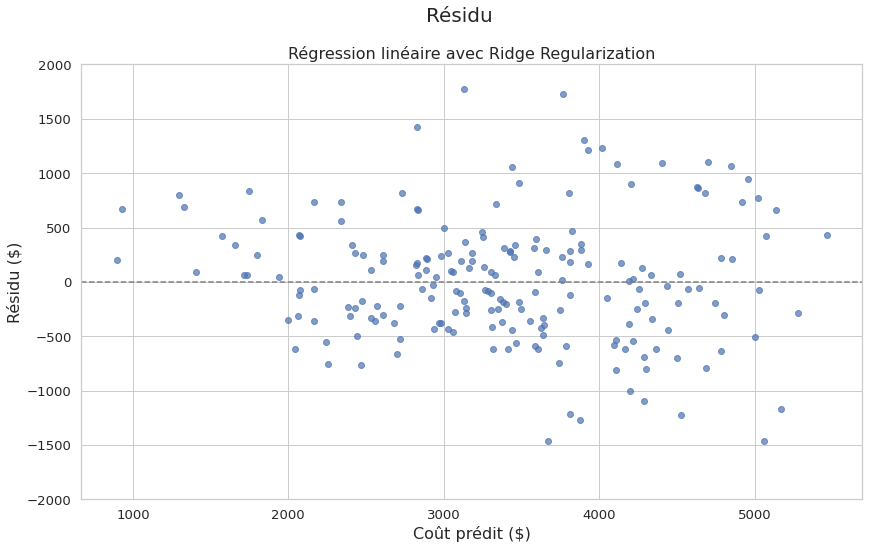

In [ ]:
plt.figure(figsize=(14, 8))
plt.scatter(rid_predict, rid_residual, alpha=.7)   

plt.axhline(0, linestyle='--', color='grey')
plt.suptitle('Résidu', fontsize=20, fontname='Arial')
plt.title('Régression linéaire avec Ridge Regularization', fontsize=16, fontname='Arial')
plt.ylim(-2000, 2000)
plt.xlabel('Coût prédit ($)', fontsize=16, fontname='Arial')
plt.ylabel('Résidu ($)', fontsize=16, fontname='Arial');

In [ ]:
plt.savefig('ridge_residue.png')

<Figure size 432x288 with 0 Axes>

#### Distribution of the rental prices 

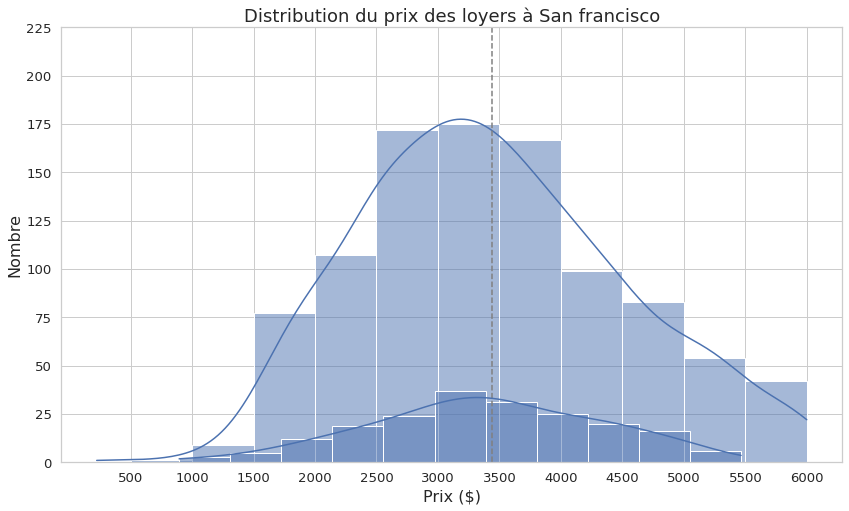

In [ ]:
plt.figure(figsize=(14, 8))
ax_actual = sns.histplot(sf.price, kde=True, bins=(list(range(500, 6001, 500))))
plt.axvline(sf.price.mean(), linestyle='--', color='grey')

ax_predict = sns.histplot(rid_predict, kde=True)

ax_actual.set_title('Distribution du prix des loyers à San francisco', fontname='Arial', fontsize=18)
ax_actual.set_xlabel('Prix ($)', fontname='Arial', fontsize=16)
ax_actual.set_ylabel('Nombre', fontname='Arial', fontsize=16)
ax_actual.set_yticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225])
ax_actual.set_xticks(list(range(500, 6001, 500)))
ax_actual.set_xticklabels(list(range(500, 6001, 500)));

In [ ]:
plt.savefig('Prix_distribution.png')

<Figure size 432x288 with 0 Axes>